In [2]:
import os
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
from qiime2 import Artifact

%matplotlib inline

In [4]:
Data = 'Data'

In [5]:
Data_classified = 'Data/classified'

In [6]:
Data_raw = 'Data/raw'

In [7]:
Data_alpha = 'Data/diversity'

### 1) Alpha rarefaction: choose the sampling depth ###

In [8]:
! qiime diversity alpha-rarefaction \
    --i-table $Data_classified/table-filtered.qza \
    --p-max-depth 10000 \
    --p-iterations 10 \
    --m-metadata-file $Data_raw/20250913_metadata_ITS.tsv \
    --o-visualization $Data_alpha/alpha-rarefaction.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/alpha-rarefaction.qzv


In [9]:
Visualization.load(f"{Data_alpha}/alpha-rarefaction.qzv")

<visualization: Visualization uuid: 02eb71ee-7e93-488c-a7c2-0bac05b4ca7c>

In [10]:
Visualization.load(f"{Data_classified}/table-filtered.qzv")

<visualization: Visualization uuid: 5af5a6d9-860b-4a95-a0c1-6dc8d98f9d4c>

### 2) we chose a sampling depth of 3000 because it can retain 87% of the samples


### 3) Core metrics creation with sampling depth 3000 ###

In [12]:
! qiime diversity core-metrics \
  --i-table $Data_classified/table-filtered.qza \
  --m-metadata-file $Data_raw/20250913_metadata_ITS.tsv \
  --p-sampling-depth 3000 \
  --output-dir $Data_alpha/core-metrics-results

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/diversity/core-metrics-results/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results/evenness_vector.qza
Saved DistanceMatrix to: Data/diversity/core-metrics-results/jaccard_distance_matrix.qza
Saved DistanceMatrix to: Data/diversity/core-metrics-results/bray_curtis_distance_matrix.qza
Saved PCoAResults to: Data/diversity/core-metrics-results/jaccard_pcoa_results.qza
Saved PCoAResults to: Data/dive

### 4) Test data for normal distribution (parametric testing) ###

In [13]:
#Testen, whether normally distributed!
from scipy.stats import shapiro

shannon_path = f"{Data_alpha}/core-metrics-results/shannon_vector.qza"
shannon = q2.Artifact.load(shannon_path).view(pd.Series)

stat, p = shapiro(shannon)
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print("Daten wahrscheinlich normalverteilt")
else:
    print("Daten wahrscheinlich nicht normalverteilt")

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Statistics=0.928, p=0.000
Daten wahrscheinlich nicht normalverteilt


/opt/conda/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')


### 5) Kruskal-Wallis: Non-parametric testing ###

### 5.1) Kruskal-Wallis for the metadata ITS: ###

In [14]:
! qiime diversity alpha-group-significance \
  --i-alpha-diversity $Data_alpha/core-metrics-results/shannon_vector.qza \
  --m-metadata-file $Data_raw/20250913_metadata_ITS.tsv \
  --o-visualization $Data_alpha/core-metrics-results/shannon-group-significance.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/core-metrics-results/shannon-group-significance.qzv


In [16]:
Visualization.load(f"{Data_alpha}/core-metrics-results/shannon-group-significance.qzv")

<visualization: Visualization uuid: d3fc9d73-9a2b-43de-b0b4-dd89917c7649>

### 5.2) Kruskal-Wallis for the metadata personal environment: ###

**But first, merge the two metadata files**

In [17]:
its = pd.read_csv("Data/raw/20250913_metadata_ITS.tsv", sep="\t")

sensory = pd.read_csv("Data/raw/20250914_metadata_personal_environmental_sensory_details.tsv", sep="\t")

# merge, keep all ITS
merged = its.merge(
    sensory,
    left_on='person-id',
    right_on='person-id',
    how='left'
)
# safe
merged.to_csv("Data/raw/merged_output.tsv", sep="\t", index=False)


left_on='person-id' → Wir nehmen die IDs aus der ITS-Tabelle.
right_on='sample-id' → Wir vergleichen sie mit den IDs aus der Sensory-Tabelle.
how='left' → Wir behalten alle ITS-Samples, auch wenn es keinen passenden Eintrag in Sensory gibt.
Ergebnis: Eine neue Tabelle (merged), die alle ITS-Samples enthält, und Sensory-Daten dort hinzufügt, wo sie verfügbar sind.

Wichtiger Punkt:

Wenn ein Sample keine Sensory-Daten hat, sind die entsprechenden Spalten NaN (leer).

In [68]:
! qiime diversity alpha-group-significance \
  --i-alpha-diversity $Data_alpha/core-metrics-results/shannon_vector.qza \
  --m-metadata-file $Data_raw/merged_output.tsv \
  --o-visualization $Data_alpha/core-metrics-results/shannon-group-significance-environment.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/core-metrics-results/shannon-group-significance-environment.qzv


In [30]:
Visualization.load(f"{Data_alpha}/core-metrics-results/shannon-group-significance-environment.qzv")

<visualization: Visualization uuid: 3837ef0e-c6bf-4c85-ac73-1b11da717925>

### 6) Alpha Correlation ###

### 6.1) Alpha Correlation for the metadata ITS ###

In [ ]:
! qiime diversity alpha-correlation \
  --i-alpha-diversity $Data_alpha/core-metrics-results/shannon_vector.qza \
  --m-metadata-file $Data_raw/20250913_metadata_ITS.tsv \
  --o-visualization $Data_alpha/core-metrics-results/shannon-group-significance-numeric.qzv

In [33]:
Visualization.load(f"{Data_alpha}/core-metrics-results/shannon-group-significance-numeric.qzv")

<visualization: Visualization uuid: 15be04d1-0002-4fb2-8f21-a44956e689cd>

--> kategoriale spalten wurden in kruskal wallis ausgewertet, numerische in alpha correlation


### 6.2) Alpha Correlation for the metadata personal environment: ###

In [40]:
from qiime2 import Artifact
shannon_series = (Artifact.load(f"{Data_alpha}/core-metrics-results/shannon_vector.qza")).view(pd.Series)
shannon = shannon_series.to_frame()

metadata_merged = pd.read_csv(f"{Data_raw}/merged_output.tsv", sep = "\t", index_col=0) 

#joining metadata (merged) with the shannon entropy vector
join = shannon.join(metadata_merged, how='inner')
join.index.name = 'sampleID'
join

/opt/conda/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')


,shannon_entropy,label_barcode1,label_barcode2,created_date,amplicon,unique_id,sample_id,person-id,plate,plate_position,...,animal_score_D28,chemical_score_D28,body_odour_score_D28,fruity_score_D28,maillard_score_D28,sour_score_D28,ocean_score_D28,earthy_score_D28,fermented_dairy_score_D28,nutty_score_D28
sampleID,,,,,,,,,,,,,,,,,,,,,
366291_001-LP4-ITS-0001,6.526281,ATATTTAGGTAT,CTACCGATTGCG,16.10.2024 14:59,ITS,LP4-ITS-0001,1701-d0-r,1701.0,P1,A01,...,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
366291_002-LP4-ITS-0002,7.330280,AGTACTGCAGGC,ATTTGCTTTGCC,16.10.2024 14:59,ITS,LP4-ITS-0002,1707-d0-r,1707.0,P1,B01,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
366291_003-LP4-ITS-0003,4.429465,CGGGTGAACCAT,GTGACCCTGTCA,16.10.2024 14:59,ITS,LP4-ITS-0003,1713-d0-r,1713.0,P1,C01,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
366291_004-LP4-ITS-0004,6.128831,CCTGGTCCACGG,GAGAATGGAAAG,16.10.2024 14:59,ITS,LP4-ITS-0004,1719-d0-r,1719.0,P1,D01,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
366291_005-LP4-ITS-0005,3.435645,GATAATAGGGAC,CAGTAGCGATAT,16.10.2024 14:59,ITS,LP4-ITS-0005,1724-d0-l,1724.0,P1,E01,...,0.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366292_106-LP4-ITS-0606,1.018014,GGCGTTTGCCTC,CTTGAGAAATCG,16.10.2024 14:59,ITS,LP4-ITS-0606,1707-d21-1,1707.0,P7,F04,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
366292_107-LP4-ITS-0607,0.949161,AGGCATCTTACG,ACGGCCCTGGAG,16.10.2024 14:59,ITS,LP4-ITS-0607,1810-d7-1,1810.0,P7,G04,...,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0
366292_108-LP4-ITS-0608,1.368541,TTCAAATATTAG,CTGTAAAGGTTG,16.10.2024 14:59,ITS,LP4-ITS-0608,1705-d14-1,1705.0,P7,H04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 6.2.1) Spearman correlation für numerische Daten ###

In [39]:
numeric_metadata = metadata_merged.select_dtypes(include='number')
joined = shannon.join(numeric_metadata, how='inner')

# Spearman-correlations calculations
correlations = joined.corr(method='spearman')['shannon_entropy']
correlations = correlations.drop('shannon_entropy')  #remove shannon entropy as a row
correlations = correlations.dropna()
correlations

person-id                   -0.045124
amplicon_conc               -0.155935
day                         -0.219141
sd_stor_temp                -0.042050
hands_disinfect             -0.046530
                               ...   
maillard_score_D28           0.095561
sour_score_D28              -0.050183
earthy_score_D28            -0.009860
fermented_dairy_score_D28   -0.003985
nutty_score_D28             -0.007308
Name: shannon_entropy, Length: 211, dtype: float64

In [32]:
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

p_values = {}
for col in numeric_metadata.columns:
    corr, p = spearmanr(joined['shannon_entropy'], joined[col])
    p_values[col] = p

p_values_df = (pd.DataFrame.from_dict(p_values, orient='index', columns=['p_value'])).join(correlations, how = "inner")
p_values_df = p_values_df.dropna(subset=['p_value'])

pvals = p_values_df['p_value'].values

reject, pvals_corr, _, _ = multipletests(pvals, method='fdr_bh')

p_values_df['p_value_FDR'] = pvals_corr
p_values_df['significant_FDR'] = reject

# Ergebnis anzeigen

p_values_df

,p_value,shannon_entropy,p_value_FDR,significant_FDR
amplicon_conc,0.000623,-0.155935,0.000623,True


### 7) Kruskal Wallis evaluations ###

***7.1) label barcode 1***

In [66]:
kruskal_barcode1 = pd.read_csv(f"{Data_alpha}/kruskal-wallis-pairwise-label_barcode1.csv", sep = ",", index_col=0)
sig = kruskal_barcode1[kruskal_barcode1['p-value'] <= 0.05]


grouped = sig.groupby('Group 1').size()
print(grouped)

Group 1
AAGTCTCCTGAG (n=12)    26
AATATCAGACGA (n=8)     21
ACCAGACGATGC (n=5)     32
AGACCGTCAGAC (n=2)      3
AGCGTAGGTCGT (n=8)     22
AGGCATCTTACG (n=3)     24
AGGGCTTGTAGC (n=12)    23
AGTACTGCAGGC (n=12)    31
ATAATCTCGTCG (n=12)    26
ATACGGGCGCAT (n=7)     27
ATATTTAGGTAT (n=12)    20
ATCACTAGTCAC (n=7)     18
ATGCCGCGTCGC (n=12)    24
CAAATCTTAAGA (n=5)     21
CAACCCGAGAGG (n=3)     24
CAAGCATGCCTA (n=10)    19
CACCTCAACTCC (n=7)     22
CATAGCGAGTTC (n=12)    16
CCTGGTCCACGG (n=12)    16
CGGGTGAACCAT (n=12)    17
CTGTAGGAGACC (n=6)     19
CTGTGCGGGTAA (n=12)    20
CTTACTTATCGA (n=12)    15
CTTCACCGGTCG (n=8)     17
GAGACAGCTTGC (n=10)    19
GATAATAGGGAC (n=12)    14
GATCGGGTCGGA (n=8)     17
GATTGTACTCGG (n=8)     11
GCATTAACCTGG (n=12)    15
GCCCAATATGTG (n=5)     16
GCCCACAGGGCC (n=3)     15
GCCTACCGCCTA (n=8)     14
GCTGCAAATCTT (n=11)    10
GGAAGTGAAGTT (n=6)     15
GGATATGTCCCA (n=7)     13
GGCGCCAGAGAT (n=12)     6
GGCGTTTGCCTC (n=3)     15
GTAAAGATCACA (n=8)      6
GTGA

***7.2) Plate***

In [76]:
kruskal_plate = pd.read_csv(f"{Data_alpha}/kruskal-wallis-pairwise-plate.csv", sep = ",", index_col=0)
sig = kruskal_plate[kruskal_plate['p-value'] <= 0.05]
sig

,Group 2,H,p-value,q-value
Group 1,,,,
P1 (n=96),P3 (n=93),6.573967,1.034810e-02,1.671617e-02
P1 (n=96),P5 (n=55),89.530637,3.019265e-21,3.170228e-20
P1 (n=96),P6 (n=55),91.739369,9.887805e-22,2.076439e-20
P1 (n=96),P7 (n=20),42.694231,6.400077e-11,1.493351e-10
P2 (n=96),P5 (n=55),85.408194,2.427128e-20,1.274242e-19
P2 (n=96),P6 (n=55),86.699522,1.263274e-20,8.842916e-20
P2 (n=96),P7 (n=20),41.273558,1.323472e-10,2.779290e-10
P3 (n=93),P5 (n=55),80.171501,3.432828e-19,1.201490e-18
P3 (n=93),P6 (n=55),83.328548,6.948880e-20,2.918530e-19


In [75]:
plate = sig.groupby('Group 1').size()
plate

Group 1
P1 (n=96)    4
P2 (n=96)    3
P3 (n=93)    3
P4 (n=63)    3
dtype: int64

***7.3) DNA extraction***

In [68]:
kruskal_DNA = pd.read_csv(f"{Data_alpha}/kruskal-wallis-pairwise-DNA_extraction_plate.csv", sep = ",", index_col=0)
sig = kruskal_DNA[kruskal_DNA['p-value'] <= 0.05]
sig

,Group 2,H,p-value,q-value
Group 1,,,,
DNA55 (n=96),DNA57 (n=93),6.573967,1.034810e-02,1.671617e-02
DNA55 (n=96),DNA59 (n=55),89.530637,3.019265e-21,3.170228e-20
DNA55 (n=96),DNA60 (n=55),91.739369,9.887805e-22,2.076439e-20
DNA55 (n=96),DNA61 (n=20),42.694231,6.400077e-11,1.493351e-10
DNA56 (n=96),DNA59 (n=55),85.408194,2.427128e-20,1.274242e-19
DNA56 (n=96),DNA60 (n=55),86.699522,1.263274e-20,8.842916e-20
DNA56 (n=96),DNA61 (n=20),41.273558,1.323472e-10,2.779290e-10
DNA57 (n=93),DNA59 (n=55),80.171501,3.432828e-19,1.201490e-18
DNA57 (n=93),DNA60 (n=55),83.328548,6.948880e-20,2.918530e-19


***7.4) Project***

In [70]:
kruskal_project = pd.read_csv(f"{Data_alpha}/kruskal-wallis-pairwise-project.csv", sep = ",", index_col=0)
sig = kruskal_project[kruskal_project['p-value'] <= 0.05]
sig

,Group 2,H,p-value,q-value
Group 1,,,,
highschool (n=130),highschool_hs (n=348),236.09083,2.799675e-53,2.799675e-53


***7.5) Sample type***

In [71]:
kruskal_type = pd.read_csv(f"{Data_alpha}/kruskal-wallis-pairwise-sample_type.csv", sep = ",", index_col=0)
sig = kruskal_type[kruskal_type['p-value'] <= 0.05]
sig

,Group 2,H,p-value,q-value
Group 1,,,,
control_n (n=6),control_p (n=8),6.016667,1.417139e-02,2.834278e-02
control_n (n=6),hand_swabs (n=338),13.769248,2.066921e-04,6.889735e-04
control_p (n=8),hand_swabs (n=338),22.283990,2.351591e-06,1.175796e-05
control_pcr (n=4),hand_swabs (n=338),10.303129,1.328048e-03,3.320120e-03
hand_swabs (n=338),sourdough (n=122),230.359932,4.975626e-52,4.975626e-51


### 8) Kruskal-Wallis: Non-parametric testing only for sourdoughs ###

***8.1) Filtering out sourdough***

In [12]:
! qiime feature-table filter-samples \
  --i-table $Data_classified/table-filtered.qza \
  --m-metadata-file $Data_raw/merged_output.tsv  \
  --p-where "sample_type='sourdough'" \
  --o-filtered-table $Data_classified/table-filtered-sourdough_only.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/classified/table-filtered-sourdough_only.qza


In [16]:
! qiime diversity core-metrics \
  --i-table $Data_classified/table-filtered-sourdough_only.qza \
  --m-metadata-file $Data_raw/merged_output.tsv \
  --p-sampling-depth 3000 \
  --output-dir $Data_alpha/core-metrics-results-sourdough_only

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/diversity/core-metrics-results-sourdough_only/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-sourdough_only/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-sourdough_only/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-sourdough_only/evenness_vector.qza
Saved DistanceMatrix to: Data/diversity/core-metrics-results-sourdough_only/jaccard_distance_matrix.qza
Saved DistanceMatrix to: Data/diversity/core-metrics-results-sourdough_only/bray_curtis_distance_matrix.qza
Saved PCoAResults to: Da

In [17]:
! qiime diversity alpha-group-significance \
  --i-alpha-diversity $Data_alpha/core-metrics-results-sourdough_only/shannon_vector.qza \
  --m-metadata-file $Data_raw/merged_output.tsv \
  --o-visualization $Data_alpha/core-metrics-results-sourdough_only/shannon-group-significance-sourdough.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/core-metrics-results-sourdough_only/shannon-group-significance-sourdough.qzv


In [6]:
Visualization.load(f"{Data_alpha}/core-metrics-results-sourdough_only/shannon-group-significance-sourdough.qzv")

<visualization: Visualization uuid: 87b820c1-7d19-41e9-8f8f-22a23a383320>

notes: conditions significant only for sourdough =
1) background (sterile, non-sterile)
2) sd_bake_last time - nur zwei samples, also schon significant aber useless

***8.2.1) Visualization sourdough***

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Metadata laden (möglicherweise hast du merged_output.tsv)
metadata = pd.read_csv(f"{Data_raw}/merged_output.tsv", sep='\t', index_col=0)

shannon_qza = q2.Artifact.load(f"{Data_alpha}/core-metrics-results-sourdough_only/shannon_vector.qza")
shannon_df = shannon_qza.view(pd.Series).to_frame(name='shannon')
shannon_df.index.name = 'SampleID'

shannon_df.head()

/opt/conda/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')


,shannon
SampleID,
366291_386-LP4-ITS-0386,1.628283
366291_387-LP4-ITS-0387,4.487673
366291_388-LP4-ITS-0388,2.084626
366291_389-LP4-ITS-0389,0.964727
366291_390-LP4-ITS-0390,2.497893


In [14]:
df = shannon_df.join(metadata)
df.head()


,shannon,label_barcode1,label_barcode2,created_date,amplicon,unique_id,sample_id,person-id,plate,plate_position,...,animal_score_D28,chemical_score_D28,body_odour_score_D28,fruity_score_D28,maillard_score_D28,sour_score_D28,ocean_score_D28,earthy_score_D28,fermented_dairy_score_D28,nutty_score_D28
SampleID,,,,,,,,,,,,,,,,,,,,,
366291_386-LP4-ITS-0386,1.628283,GGAAGTGAAGTT,ATTTGCTTTGCC,16.10.2024 14:59,ITS,LP4-ITS-0386,1820-d21-1,1820.0,P5,B01,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
366291_387-LP4-ITS-0387,4.487673,GATCGGGTCGGA,GTGACCCTGTCA,16.10.2024 14:59,ITS,LP4-ITS-0387,1725-d7-1,1725.0,P5,C01,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
366291_388-LP4-ITS-0388,2.084626,GTGACCTGATGT,GAGAATGGAAAG,16.10.2024 14:59,ITS,LP4-ITS-0388,1806-d14-1,1806.0,P5,D01,...,0.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
366291_389-LP4-ITS-0389,0.964727,GCCTACCGCCTA,CAGTAGCGATAT,16.10.2024 14:59,ITS,LP4-ITS-0389,1723-d21-1,1723.0,P5,E01,...,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
366291_390-LP4-ITS-0390,2.497893,ATACGGGCGCAT,GCCAAGGATAGG,16.10.2024 14:59,ITS,LP4-ITS-0390,1706-d7-1,1706.0,P5,F01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
!pip install statannot

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


ValueError: box_pairs contains an invalid box pair.

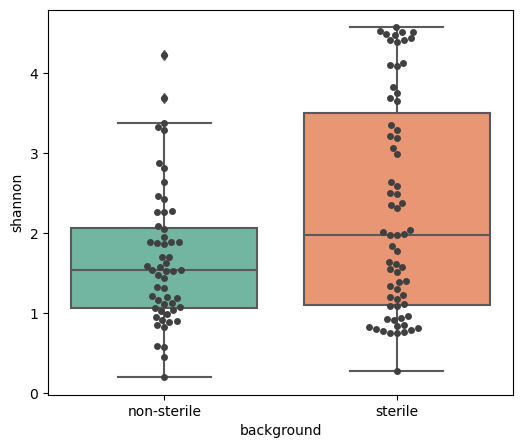

In [25]:
#Darstellung von sterile non-sterile boxplot klären

plt.figure(figsize=(6,5))
ax = sns.boxplot(x='background', y='shannon', data=df, palette='Set2')
sns.swarmplot(x='background', y='shannon', data=df, color='0.25', ax=ax)

# Whitespace entfernen
df['background'] = df['background'].str.strip()

add_stat_annotation(
    ax, 
    data=df, 
    x='background', 
    y='shannon',
    box_pairs=[("Sterile", "Non sterile")],  # genau wie in df['background'].unique()
    test='t-test_ind',
    text_format='star',
    loc='outside',
    verbose=2
)

ax.set_xlabel('Background', labelpad=15)
ax.set_ylabel('Shannon Diversity', labelpad=15)
ax.set_title('Alpha-Diversity of Background', size=16, pad=15)

plt.show()


***8.2) Alpha-Correlation for sourdough***

In [7]:
from qiime2 import Artifact
shannon_series = (Artifact.load(f"{Data_alpha}/core-metrics-results-sourdough_only/shannon_vector.qza")).view(pd.Series)
shannon = shannon_series.to_frame()

metadata_merged = pd.read_csv(f"{Data_raw}/merged_output.tsv", sep = "\t", index_col=0) 

#joining metadata (merged) with the shannon entropy vector for sourdough
join = shannon.join(metadata_merged, how='inner')
join.index.name = 'sampleID'
join

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/opt/conda/lib/python3.10/site-packages/q2_types/sample_data/_deferred_setup/_transformers.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')


,shannon_entropy,label_barcode1,label_barcode2,created_date,amplicon,unique_id,sample_id,person-id,plate,plate_position,...,animal_score_D28,chemical_score_D28,body_odour_score_D28,fruity_score_D28,maillard_score_D28,sour_score_D28,ocean_score_D28,earthy_score_D28,fermented_dairy_score_D28,nutty_score_D28
sampleID,,,,,,,,,,,,,,,,,,,,,
366291_386-LP4-ITS-0386,1.628283,GGAAGTGAAGTT,ATTTGCTTTGCC,16.10.2024 14:59,ITS,LP4-ITS-0386,1820-d21-1,1820.0,P5,B01,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
366291_387-LP4-ITS-0387,4.487673,GATCGGGTCGGA,GTGACCCTGTCA,16.10.2024 14:59,ITS,LP4-ITS-0387,1725-d7-1,1725.0,P5,C01,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
366291_388-LP4-ITS-0388,2.084626,GTGACCTGATGT,GAGAATGGAAAG,16.10.2024 14:59,ITS,LP4-ITS-0388,1806-d14-1,1806.0,P5,D01,...,0.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
366291_389-LP4-ITS-0389,0.964727,GCCTACCGCCTA,CAGTAGCGATAT,16.10.2024 14:59,ITS,LP4-ITS-0389,1723-d21-1,1723.0,P5,E01,...,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
366291_390-LP4-ITS-0390,2.497893,ATACGGGCGCAT,GCCAAGGATAGG,16.10.2024 14:59,ITS,LP4-ITS-0390,1706-d7-1,1706.0,P5,F01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366292_105-LP4-ITS-0605,3.063752,GCCCACAGGGCC,ATGTATCAATTA,16.10.2024 14:59,ITS,LP4-ITS-0605,1723-d7-1,1723.0,P7,E04,...,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
366292_106-LP4-ITS-0606,0.913954,GGCGTTTGCCTC,CTTGAGAAATCG,16.10.2024 14:59,ITS,LP4-ITS-0606,1707-d21-1,1707.0,P7,F04,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
366292_107-LP4-ITS-0607,0.955830,AGGCATCTTACG,ACGGCCCTGGAG,16.10.2024 14:59,ITS,LP4-ITS-0607,1810-d7-1,1810.0,P7,G04,...,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0


In [8]:
numeric_metadata = metadata_merged.select_dtypes(include='number')
joined = shannon.join(numeric_metadata, how='inner')

# Spearman-correlations calculations
correlations = joined.corr(method='spearman')['shannon_entropy']
correlations = correlations.drop('shannon_entropy')  #remove shannon entropy as a row
correlations = correlations.dropna()
correlations

person-id                   -0.156164
amplicon_conc               -0.347891
day                         -0.208573
sd_stor_temp                 0.102024
hands_disinfect             -0.098129
                               ...   
maillard_score_D28          -0.011651
sour_score_D28              -0.060633
earthy_score_D28            -0.150860
fermented_dairy_score_D28   -0.100427
nutty_score_D28              0.122116
Name: shannon_entropy, Length: 211, dtype: float64

In [10]:
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

p_values = {}
for col in numeric_metadata.columns:
    corr, p = spearmanr(joined['shannon_entropy'], joined[col])
    p_values[col] = p

p_values_df = (pd.DataFrame.from_dict(p_values, orient='index', columns=['p_value'])).join(correlations, how = "inner")
p_values_df = p_values_df.dropna(subset=['p_value'])

pvals = p_values_df['p_value'].values

reject, pvals_corr, _, _ = multipletests(pvals, method='fdr_bh')

p_values_df['p_value_FDR'] = pvals_corr
p_values_df['significant_FDR'] = reject

# Ergebnis anzeigen

p_values_df

/tmp/ipykernel_317/2200265867.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p = spearmanr(joined['shannon_entropy'], joined[col])


,p_value,shannon_entropy,p_value_FDR,significant_FDR
person-id,0.085853,-0.156164,0.700033,False
amplicon_conc,0.000086,-0.347891,0.009140,True
day,0.021141,-0.208573,0.379804,False
ANIMAL FEED_D7,0.288172,0.096933,0.776938,False
ANIMAL STABLE_D7,0.352428,0.084910,0.794838,False
...,...,...,...,...
VEGETAL_D21,0.204539,0.115670,0.776938,False
VINEGAR_D21,0.054664,0.174427,0.482864,False
WHOLE GRAIN_D21,0.824464,-0.020288,0.979607,False
YEASTY_D21,0.307844,0.093082,0.776938,False


In [38]:
significant_results = p_values_df[p_values_df['significant_FDR'] == True]
significant_results

#was genau bedeutet significant FDR?

,p_value,shannon_entropy,p_value_FDR,significant_FDR
amplicon_conc,0.000086,-0.347891,0.00914,True
